In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from math import sqrt

In [2]:
# Load dataset
file_path = 'data/stock_news_reddit_df_v2.csv'
data = pd.read_csv(file_path)

# Convert Date to datetime format for proper filtering
data["Date"] = pd.to_datetime(data["Date"])

# Define the training and testing periods
train_start, train_end = "2024-11-01", "2025-01-31"
test_start, test_end = "2025-02-01", "2025-02-07"

# Filter the dataset based on the given time ranges
train_data = data[(data["Date"] >= train_start) & (data["Date"] <= train_end)].copy()
test_data = data[(data["Date"] >= test_start) & (data["Date"] <= test_end)].copy()

# Select features and target variable
feature_columns = ['Close', 'Return', 'Log_Return', 'MA_7', 'Volatility',
                  'news_sentiment', 'news_avg_1d', 'news_avg_3d', 'news_avg_5d',
                  'reddit_sentiment', 'reddit_avg_1d', 'reddit_avg_3d', 'reddit_avg_5d']

X_train = train_data[feature_columns]
X_test = test_data[feature_columns]

# Target: Shift Close price to predict the next day’s closing price
y_train = train_data["Close"].shift(-1).dropna()
y_test  = test_data["Close"].shift(-1).dropna()

# Ensure X and y are aligned
X_train = X_train.iloc[:-1]
X_test = X_test.iloc[:-1]

# Normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize target variable separately
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

In [3]:
# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test data
xgb_y_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy metrics for XGBoost
xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_y_pred))

In [4]:
# Reshape data for LSTM (samples, time steps, features)
lstm_X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
lstm_X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()

# First LSTM layer
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.3))

# Second LSTM layer
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dropout(0.3))

# Output layer
lstm_model.add(Dense(units=1))

# Compile the LSTM model with Adam optimizer and learning rate scheduling
optimizer = Adam(learning_rate=0.0005)
lstm_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the LSTM model
history = lstm_model.fit(lstm_X_train, y_train, epochs=100, batch_size=5, verbose=0)

# Predict & Inverse Transform
lstm_y_pred = lstm_model.predict(lstm_X_test)

# Calculate accuracy metrics for LSTM
lstm_r2 = r2_score(y_test, lstm_y_pred)
lstm_mae = mean_absolute_error(y_test, lstm_y_pred)
lstm_rmse = sqrt(mean_squared_error(y_test, lstm_y_pred))

In [5]:
xgb_results = {
    "Model": "XGBoost",
    "R² Score": xgb_r2,
    "MAE": xgb_mae,
    "RMSE": xgb_rmse
}

lstm_results = {
    "Model": "LSTM",
    "R² Score": lstm_r2,
    "MAE": lstm_mae,
    "RMSE": lstm_rmse
}

results_df = pd.DataFrame([xgb_results, lstm_results])
print(results_df)

     Model  R² Score       MAE      RMSE
0  XGBoost -1.601203  0.238367  0.272518
1     LSTM  0.722595  0.075516  0.088995


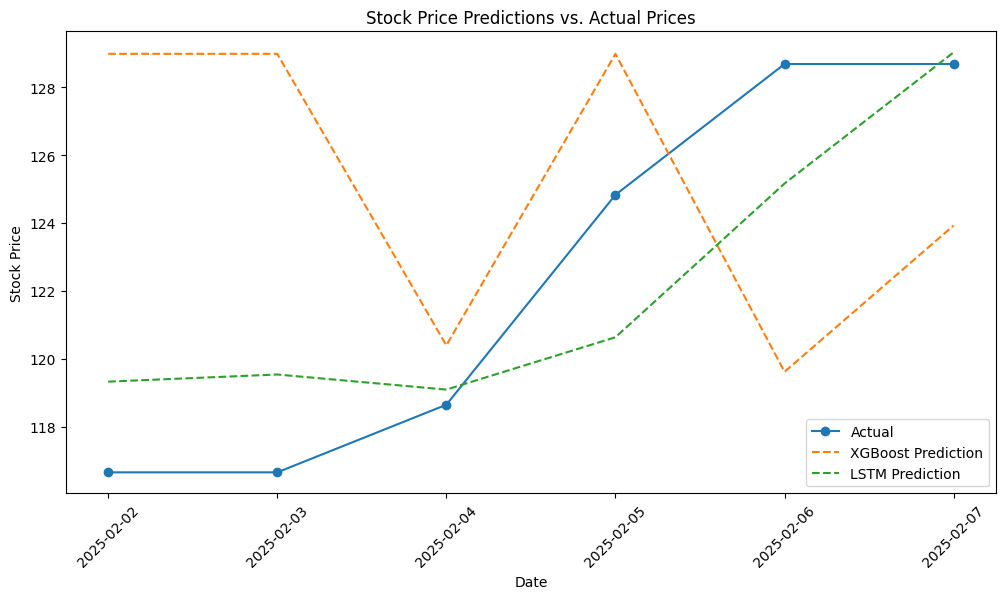

In [6]:
import matplotlib.pyplot as plt

dates = test_data["Date"].iloc[1:].to_numpy()

# Ensure predictions and actual values are properly formatted
actual_close_inv = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()
xgb_pred_inv = y_scaler.inverse_transform(xgb_y_pred.reshape(-1, 1)).flatten()
lstm_pred_inv = y_scaler.inverse_transform(lstm_y_pred.reshape(-1, 1)).flatten()

# Create a DataFrame for visualization
predictions_df = pd.DataFrame({
    "Date": dates,
    "Actual_Close": actual_close_inv,
    "XGBoost_Pred": xgb_pred_inv,
    "LSTM_Pred": lstm_pred_inv
})

dates = predictions_df["Date"].to_numpy()
actual_close = predictions_df["Actual_Close"].to_numpy()
xgb_pred = predictions_df["XGBoost_Pred"].to_numpy()
lstm_pred = predictions_df["LSTM_Pred"].to_numpy()

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_close, label="Actual", marker='o')
plt.plot(dates, xgb_pred, label="XGBoost Prediction", linestyle='dashed')
plt.plot(dates, lstm_pred, label="LSTM Prediction", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Predictions vs. Actual Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()